In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, roc_auc_score, confusion_matrix)
from sentence_transformers import SentenceTransformer
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import os

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Usando dispositivo: {device}")

Usando dispositivo: cpu


# PROMPTS


In [ ]:
import pandas as pd

# Cargar dataset
data = pd.read_csv("/content/drive/MyDrive/avances/cvs/originales/MDS-UPDRS_Part_III_28Oct2025_estandarizado_pd_mbrs (1).csv")
df_parkinson = pd.DataFrame(data)

# Agregar columna 'grupo' con todos los valores en 1
df_parkinson["grupo"] = 1

# Diccionario de descripciones en español
descripciones_es = {
    'Edad': 'edad', 'Genero': 'género', 'NP3BRADY': 'bradicinesia',
    'NP3FACXP': 'expresión facial reducida', 'NP3FRZGT': 'freezing de la marcha',
    'NP3FTAPL': 'tapping pie izquierdo', 'NP3FTAPR': 'tapping pie derecho',
    'NP3GAIT': 'alteración de la marcha', 'NP3HMOVL': 'movimiento mano izquierda',
    'NP3HMOVR': 'movimiento mano derecha', 'NP3KTRML': 'kinésia mano izquierda',
    'NP3KTRMR': 'kinésia mano derecha', 'NP3LGAGL': 'agilidad pierna izquierda',
    'NP3LGAGR': 'agilidad pierna derecha', 'NP3POSTR': 'postura',
    'NP3PRSPL': 'temblor postural mano izquierda', 'NP3PRSPR': 'temblor postural mano derecha',
    'NP3PSTBL': 'inestabilidad postural', 'NP3PTRML': 'temblor de reposo mano izquierda',
    'NP3PTRMR': 'temblor de reposo mano derecha', 'NP3RIGLL': 'rigidez pierna izquierda',
    'NP3RIGLU': 'rigidez brazo izquierdo', 'NP3RIGN': 'rigidez cuello',
    'NP3RIGRL': 'rigidez pierna derecha', 'NP3RIGRU': 'rigidez brazo derecho',
    'NP3RISNG': 'dificultad para levantarse', 'NP3RTALJ': 'temblor de acción pierna izquierda',
    'NP3RTALL': 'temblor de acción pierna izquierda', 'NP3RTALU': 'temblor de acción brazo izquierdo',
    'NP3RTARL': 'temblor de acción pierna derecha', 'NP3RTARU': 'temblor de acción brazo derecho',
    'NP3RTCON': 'constancia del temblor', 'NP3SPCH': 'alteración del habla',
    'NP3TOT': 'puntuación total MDS-UPDRS III', 'NP3TTAPL': 'tapping mano izquierda',
    'NP3TTAPR': 'tapping mano derecha', 'DBSYN': 'síntomas de estimulación cerebral',
    'DYSKPRES': 'presencia de discinesias', 'MBRS': 'escala de discinesias',
    'H & Y Stage': 'estadio Hoehn & Yahr', 'NHY': 'estadio Hoehn & Yahr numérico',
    'DBSOFFTM': 'tiempo de suspensión del tratamiento DBS', 'DBSONTM': 'tiempo de inicio del tratamiento DBS',
    'HRDBSOFF': 'horas entre el apagado del DBS y el examen NUPDRS3',
    'HRDBSON': 'horas entre el encendido del DBS y el examen NUPDRS3',
    'HRPOSTMED': 'horas entre la última dosis de medicación para EP y el examen NUPDRS3',
    'OFFEXAM': 'examen OFF realizado', 'OFFNORSN': 'motivo no realizado examen OFF',
    'ONEXAM': 'examen ON realizado', 'ONNORSN': 'motivo no realizado examen ON',
    'ONOFFORDER': 'primer examen de la Parte III OFF o ON', 'PDMEDYN': 'medicación para la EP',
    'PDSTATE': 'estado funcional actual', 'PDTRTMNT': 'tratamiento recibido',
    'Pat_id': 'ID del paciente', 'grupo': 'grupo del paciente'
}

# Diccionario de descripciones en inglés
descripciones_en = {
    'Edad': 'age', 'Genero': 'gender', 'NP3BRADY': 'bradykinesia',
    'NP3FACXP': 'reduced facial expression', 'NP3FRZGT': 'freezing of gait',
    'NP3FTAPL': 'left foot tapping', 'NP3FTAPR': 'right foot tapping',
    'NP3GAIT': 'gait impairment', 'NP3HMOVL': 'left hand movement',
    'NP3HMOVR': 'right hand movement', 'NP3KTRML': 'left hand kinesia',
    'NP3KTRMR': 'right hand kinesia', 'NP3LGAGL': 'left leg agility',
    'NP3LGAGR': 'right leg agility', 'NP3POSTR': 'posture',
    'NP3PRSPL': 'left hand postural tremor', 'NP3PRSPR': 'right hand postural tremor',
    'NP3PSTBL': 'postural instability', 'NP3PTRML': 'left hand resting tremor',
    'NP3PTRMR': 'right hand resting tremor', 'NP3RIGLL': 'left leg rigidity',
    'NP3RIGLU': 'left arm rigidity', 'NP3RIGN': 'neck rigidity',
    'NP3RIGRL': 'right leg rigidity', 'NP3RIGRU': 'right arm rigidity',
    'NP3RISNG': 'difficulty rising from chair', 'NP3RTALJ': 'left leg action tremor',
    'NP3RTALL': 'left leg action tremor', 'NP3RTALU': 'left arm action tremor',
    'NP3RTARL': 'right leg action tremor', 'NP3RTARU': 'right arm action tremor',
    'NP3RTCON': 'tremor constancy', 'NP3SPCH': 'speech impairment',
    'NP3TOT': 'MDS-UPDRS III total score', 'NP3TTAPL': 'left hand tapping',
    'NP3TTAPR': 'right hand tapping', 'DBSYN': 'deep brain stimulation symptoms',
    'DYSKPRES': 'dyskinesia presence', 'MBRS': 'dyskinesia scale',
    'H & Y Stage': 'Hoehn & Yahr stage', 'NHY': 'numeric Hoehn & Yahr stage',
    'DBSOFFTM': 'time DBS switched off', 'DBSONTM': 'time DBS switched on',
    'HRDBSOFF': 'hours from DBS off to NUPDRS3 exam',
    'HRDBSON': 'hours from DBS on to NUPDRS3 exam',
    'HRPOSTMED': 'hours from last PD medication to NUPDRS3 exam',
    'OFFEXAM': 'OFF exam performed', 'OFFNORSN': 'reason OFF exam not performed',
    'ONEXAM': 'ON exam performed', 'ONNORSN': 'reason ON exam not performed',
    'ONOFFORDER': 'order of OFF/ON Part III exams', 'PDMEDYN': 'Parkinson medication',
    'PDSTATE': 'current functional state', 'PDTRTMNT': 'treatment received',
    'Pat_id': 'patient ID', 'grupo': 'patient group'
}

def crear_prompts_parkinson(df, descripciones, idioma="es"):
    prompts = []
    for _, row in df.iterrows():
        if idioma == "es":
            tipo_paciente = "paciente con Parkinson" if row['grupo'] == 1 else "control"
        else:
            tipo_paciente = "Parkinson's patient" if row['grupo'] == 1 else "control subject"

        prompt_parts = [f"{tipo_paciente}:"]

        for col in df.columns:
            valor = row[col]

            if pd.isna(valor):
                valor = "no informado" if idioma == "es" else "not reported"
            else:
                if col == 'Genero':
                    if idioma == "es":
                        valor = "masculino" if valor == 1 else "femenino"
                    else:
                        valor = "male" if valor == 1 else "female"

            if col in descripciones:
                desc = descripciones[col]
                prompt_parts.append(f"{desc}: {valor}")
            else:
                prompt_parts.append(f"{col}: {valor}")

        prompts.append(". ".join(prompt_parts))
    return prompts

# Guardar prompts en español e inglés en columnas del DataFrame
df_parkinson["prompts_400"] = crear_prompts_parkinson(df_parkinson, descripciones_es, idioma="es")
df_parkinson["prompts_400_ing"] = crear_prompts_parkinson(df_parkinson, descripciones_en, idioma="en")

# Opcional: ver primeros 3 de cada uno
for i in range(3):
    print(f"\nPaciente {i+1} (ES):\n{df_parkinson['prompts_400'].iloc[i]}")
    print(f"\nPaciente {i+1} (EN):\n{df_parkinson['prompts_400_ing'].iloc[i]}")



Paciente 1 (ES):
paciente con Parkinson:. PATNO: 3001. EVENT_ID: V17. tratamiento recibido: 1.0. estado funcional actual: 1.0. horas entre la última dosis de medicación para EP y el examen NUPDRS3: 1.0. horas entre el encendido del DBS y el examen NUPDRS3: no informado. horas entre el apagado del DBS y el examen NUPDRS3: no informado. medicación para la EP: 1.0. síntomas de estimulación cerebral: 0.0. primer examen de la Parte III OFF o ON: 1.0. examen OFF realizado: no informado. motivo no realizado examen OFF: no informado. DBSOFFYN: no informado. tiempo de suspensión del tratamiento DBS: no informado. examen ON realizado: 1.0. motivo no realizado examen ON: no informado. HIFUYN: no informado. DBSONYN: no informado. tiempo de inicio del tratamiento DBS: no informado. alteración del habla: 2.0. expresión facial reducida: 1.0. rigidez cuello: 3.0. rigidez brazo derecho: 1.0. rigidez brazo izquierdo: 2.0. rigidez pierna derecha: 1.0. rigidez pierna izquierda: 2.0. tapping pie derecho: 

In [ ]:
# CSV en español
df_parkinson[['PATNO', 'grupo', 'prompts_400']].to_csv(
    "/content/drive/MyDrive/avances/embebidos/prompts_400_es.csv",
    index=False,
    encoding='utf-8'
)

# CSV en inglés
df_parkinson[['PATNO', 'grupo', 'prompts_400_ing']].to_csv(
    "/content/drive/MyDrive/avances/embebidos/prompts_400_ing.csv",
    index=False,
    encoding='utf-8'
)

print("Archivos prompts_400_es.csv y prompts_400_ing.csv guardados correctamente.")


Archivos prompts_400_es.csv y prompts_400_ing.csv guardados correctamente.


# ESPAÑOL

**CLINICAL-BERT**

config.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/436M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

=== Reporte (PD: Leve/Moderado/Grave con ClinicalBERT) ===
              precision    recall  f1-score   support

        Leve      1.000     1.000     1.000         5
    Moderado      1.000     0.778     0.875         9
       Grave      0.500     1.000     0.667         2

    accuracy                          0.875        16
   macro avg      0.833     0.926     0.847        16
weighted avg      0.938     0.875     0.888        16


Matriz de Confusión:
          Leve  Moderado  Grave
Leve         5         0      0
Moderado     0         7      2
Grave        0         0      2


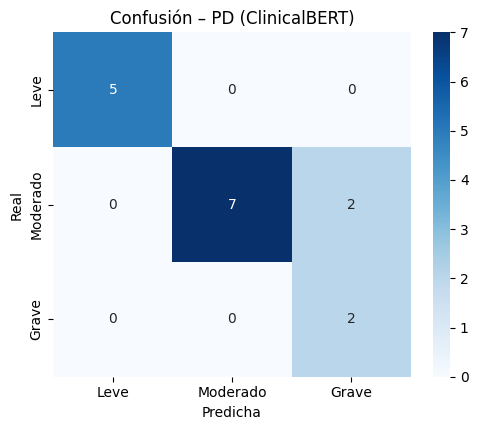

Train PD: 64 | Test PD: 16 | Device: cpu


In [ ]:
# =========================================
# PD (grupo==1): Leve/Moderado/Grave con ClinicalBERT
# =========================================
!pip install -q sentence-transformers scikit-learn pandas seaborn matplotlib transformers

import pandas as pd
import torch, seaborn as sns, matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sentence_transformers import SentenceTransformer, models

# Rutas
PROMPTS = "/content/drive/MyDrive/avances/embebidos/prompts.csv"
ORIG    = "/content/drive/MyDrive/avances/cvs/clasificación con tab y simple/DATASET_COMPLETO_ESTANDARIZADO.csv"

# Datos
df_prompts  = pd.read_csv(PROMPTS)  # requiere Pat_id, prompt
df_original = pd.read_csv(ORIG)

df = df_prompts.merge(df_original[['Pat_id','MBRS']], on='Pat_id', how='left')
df = df[df['grupo'] == 1].copy()

def clase_pd(m):
    if pd.isna(m): return -1
    if m <= 5: return 1
    if 6 <= m <= 12: return 2
    if 13 <= m <= 24: return 3
    return -1

df['clase_gravedad'] = df['MBRS'].apply(clase_pd)
df = df[df['clase_gravedad'] != -1].copy()

# Partición (reusa tus IDs PD)
train_ids = ['3102','3107','3108','3111','3113','3120','3124','3128','3134','3167','3174','3178',
             '3307','3309','3311','3314','3321','3322','3323','3327','3328','3360','3364','3366',
             '3380','3383','3552','3557','3564','3575','3585','3586','3753','3760','3764','3771',
             '3780','3789','3800','3814','3822','3826','3830','3863','4005','4006','4019','4024',
             '4025','4026','4030','4034','4035','40533','4069','40781','4081','4082','4083','40916',
             '41486','41829','50028','51731']
test_ids  = ['3105','3127','3166','3179','3181','3354','3392','3556','3577','3815','3818','3832','3867','4001','4080','51632']

pd_ids = set(df['Pat_id'].astype(str))
train_ids = [i for i in train_ids if i in pd_ids]
test_ids  = [i for i in test_ids  if i in pd_ids]

df_train = df[df['Pat_id'].astype(str).isin(train_ids)].copy()
df_test  = df[df['Pat_id'].astype(str).isin(test_ids)].copy()
assert not df_train.empty and not df_test.empty, f"Partición vacía. train={len(df_train)} test={len(df_test)}"

# ------- Embeddings: ClinicalBERT -------
device = "cuda" if torch.cuda.is_available() else "cpu"
backbone = "emilyalsentzer/Bio_ClinicalBERT"  # ClinicalBERT base

wb = models.Transformer(backbone, max_seq_length=512)
pool = models.Pooling(
    wb.get_word_embedding_dimension(),
    pooling_mode_mean_tokens=True,          # mean pooling sobre tokens
    pooling_mode_cls_token=False,
    pooling_mode_max_tokens=False
)
embedder = SentenceTransformer(modules=[wb, pool], device=device)

X_train = embedder.encode(df_train['prompt'].tolist(),
                          batch_size=32, normalize_embeddings=True,
                          convert_to_numpy=True, show_progress_bar=True)
X_test  = embedder.encode(df_test['prompt'].tolist(),
                          batch_size=32, normalize_embeddings=True,
                          convert_to_numpy=True, show_progress_bar=True)

y_train = df_train['clase_gravedad'].values
y_test  = df_test['clase_gravedad'].values

# ------- Clasificador -------
clf = RandomForestClassifier(n_estimators=300, class_weight='balanced',
                             random_state=42, n_jobs=-1)
clf.fit(X_train, y_train)

# ------- Evaluación -------
y_pred = clf.predict(X_test)
print("=== Reporte (PD: Leve/Moderado/Grave con ClinicalBERT) ===")
print(classification_report(y_test, y_pred, labels=[1,2,3],
                            target_names=["Leve","Moderado","Grave"], digits=3))

cm = confusion_matrix(y_test, y_pred, labels=[1,2,3])
cm_df = pd.DataFrame(cm, index=["Leve","Moderado","Grave"], columns=["Leve","Moderado","Grave"])
print("\nMatriz de Confusión:"); print(cm_df)

plt.figure(figsize=(5.2,4.4))
sns.heatmap(cm_df, annot=True, fmt="d", cmap="Blues")
plt.ylabel("Real"); plt.xlabel("Predicha"); plt.title("Confusión – PD (ClinicalBERT)")
plt.tight_layout(); plt.show()

print(f"Train PD: {len(df_train)} | Test PD: {len(df_test)} | Device: {device}")


In [ ]:
# ===== Guardar embebidos ClinicalBERT + metadatos =====
import os, re, numpy as np
import pandas as pd

BASE = "/content/drive/MyDrive/avances/embebidos"
tag  = re.sub(r"[^A-Za-z0-9]+", "_", backbone)  # p.ej. emilyalsentzer_Bio_ClinicalBERT
OUT  = f"{BASE}/{tag}"
os.makedirs(OUT, exist_ok=True)

# dim del embebido (768 en ClinicalBERT con mean pooling)
try:
    dim = embedder.get_sentence_embedding_dimension()
except Exception:
    dim = X_train.shape[1]

e_cols = [f"e_{i}" for i in range(dim)]

def pack(df_part, X_part, y_part, split_name):
    tmp = pd.DataFrame(X_part.astype("float32"), columns=e_cols)
    tmp["Pat_id"]         = df_part["Pat_id"].astype(str).values
    tmp["MBRS"]           = df_part["MBRS"].values
    tmp["clase_gravedad"] = y_part
    tmp["split"]          = split_name
    tmp["prompt"]         = df_part["prompt"].values
    tmp["model_name"]     = backbone
    return tmp

df_train_emb = pack(df_train, X_train, y_train, "train")
df_test_emb  = pack(df_test,  X_test,  y_test,  "test")
df_emb_cb    = pd.concat([df_train_emb, df_test_emb], ignore_index=True)

parquet_path = f"{OUT}/embeddings_pd_{tag}.parquet"
csv_path     = f"{OUT}/embeddings_pd_{tag}.csv"
npz_path     = f"{OUT}/embeddings_pd_arrays_{tag}.npz"

df_emb_cb.to_parquet(parquet_path, index=False)
df_emb_cb.to_csv(csv_path, index=False)
np.savez_compressed(
    npz_path,
    X_train=X_train, X_test=X_test,
    y_train=y_train, y_test=y_test,
    train_ids=df_train["Pat_id"].astype(str).values,
    test_ids=df_test["Pat_id"].astype(str).values,
    dim=dim, model_name=backbone
)

print("Guardado ClinicalBERT en:")
print(parquet_path)
print(csv_path)
print(npz_path)


Guardado ClinicalBERT en:
/content/drive/MyDrive/avances/embebidos/emilyalsentzer_Bio_ClinicalBERT/embeddings_pd_emilyalsentzer_Bio_ClinicalBERT.parquet
/content/drive/MyDrive/avances/embebidos/emilyalsentzer_Bio_ClinicalBERT/embeddings_pd_emilyalsentzer_Bio_ClinicalBERT.csv
/content/drive/MyDrive/avances/embebidos/emilyalsentzer_Bio_ClinicalBERT/embeddings_pd_arrays_emilyalsentzer_Bio_ClinicalBERT.npz


# **INGLÉS**

**CLINICAL-BERT**

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

CV-5 | acc=0.701±0.097  f1_macro=0.549±0.159

=== Test fijo (PD: Leve/Moderado/Grave) ===
              precision    recall  f1-score   support

        Leve      0.833     1.000     0.909         5
    Moderado      1.000     0.778     0.875         9
       Grave      0.667     1.000     0.800         2

    accuracy                          0.875        16
   macro avg      0.833     0.926     0.861        16
weighted avg      0.906     0.875     0.876        16


Matriz de Confusión:
          Leve  Moderado  Grave
Leve         5         0      0
Moderado     1         7      1
Grave        0         0      2


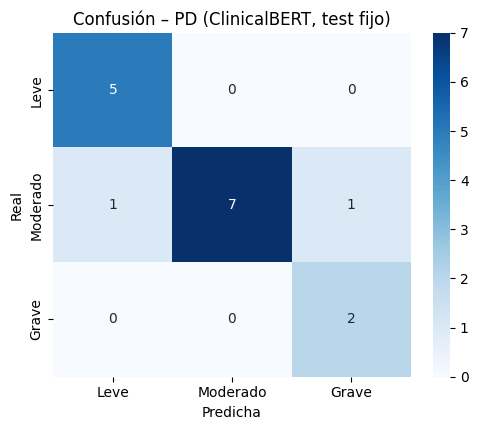

Train PD: 64 | Test PD: 16 | Device: cpu


In [ ]:
# =========================================
# PD fijo (train/test dados) + CV en train con ClinicalBERT
# =========================================
!pip install -q sentence-transformers scikit-learn pandas seaborn matplotlib transformers

import numpy as np, pandas as pd, torch, matplotlib.pyplot as plt, seaborn as sns
from sentence_transformers import SentenceTransformer, models
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score

# Rutas
PROMPTS = "/content/drive/MyDrive/avances/embebidos/prompts_ing.csv"  # tiene Pat_id, prompt, grupo
ORIG    = "/content/drive/MyDrive/avances/cvs/clasificación con tab y simple/DATASET_COMPLETO_ESTANDARIZADO.csv"

# 1) Datos
dfp = pd.read_csv(PROMPTS)
dfo = pd.read_csv(ORIG)

# Une SOLO MBRS; grupo ya está en prompts
df = dfp.merge(dfo[['Pat_id','MBRS']], on='Pat_id', how='left')
df = df[df['grupo'] == 1].copy()  # solo Parkinson

def clase_pd(m):
    if pd.isna(m): return -1
    if m <= 5: return 1
    if 6 <= m <= 12: return 2
    if 13 <= m <= 24: return 3
    return -1

df['clase_gravedad'] = df['MBRS'].apply(clase_pd)
df = df[df['clase_gravedad'] != -1].copy()

# 2) Split fijo
test_ids  = ['3105','3127','3166','3179','3181','3354','3392','3556','3577','3815','3818','3832','3867','4001','4080','51632']
train_ids = ['3102','3107','3108','3111','3113','3120','3124','3128','3134','3167','3174','3178','3307','3309','3311','3314',
             '3321','3322','3323','3327','3328','3360','3364','3366','3380','3383','3552','3557','3564','3575','3585','3586',
             '3753','3760','3764','3771','3780','3789','3800','3814','3822','3826','3830','3863','4005','4006','4019','4024',
             '4025','4026','4030','4034','4035','40533','4069','40781','4081','4082','4083','40916','41486','41829','50028','51731']

pd_ids = set(df['Pat_id'].astype(str))
train_ids = [i for i in train_ids if i in pd_ids]
test_ids  = [i for i in test_ids  if i in pd_ids]

df_train = df[df['Pat_id'].astype(str).isin(train_ids)].copy()
df_test  = df[df['Pat_id'].astype(str).isin(test_ids)].copy()
assert not df_train.empty and not df_test.empty, f"Split vacío. train={len(df_train)} test={len(df_test)}"

# 3) Embeddings ClinicalBERT (mean pooling)
device   = "cuda" if torch.cuda.is_available() else "cpu"
backbone = "emilyalsentzer/Bio_ClinicalBERT"
wb = models.Transformer(backbone, max_seq_length=512)
pool = models.Pooling(wb.get_word_embedding_dimension(), pooling_mode_mean_tokens=True)
embedder = SentenceTransformer(modules=[wb, pool], device=device)

X_train = embedder.encode(df_train['prompt_en'].tolist(), batch_size=32, normalize_embeddings=True,
                          convert_to_numpy=True, show_progress_bar=True)
X_test  = embedder.encode(df_test['prompt_en'].tolist(),  batch_size=32, normalize_embeddings=True,
                          convert_to_numpy=True, show_progress_bar=True)
y_train = df_train['clase_gravedad'].values
y_test  = df_test['clase_gravedad'].values

# 4) CV en train (k-fold estratificado) para estimar media±std
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
accs, f1mac = [], []
for tr, va in skf.split(X_train, y_train):
    clf_cv = RandomForestClassifier(n_estimators=300, class_weight='balanced', random_state=42, n_jobs=-1)
    clf_cv.fit(X_train[tr], y_train[tr])
    yp = clf_cv.predict(X_train[va])
    accs.append(accuracy_score(y_train[va], yp))
    f1mac.append(f1_score(y_train[va], yp, average='macro'))

print(f"CV-5 | acc={np.mean(accs):.3f}±{np.std(accs):.3f}  f1_macro={np.mean(f1mac):.3f}±{np.std(f1mac):.3f}")

# 5) Entrena en TODO el train y evalúa en test fijo
clf = RandomForestClassifier(n_estimators=300, class_weight='balanced', random_state=42, n_jobs=-1)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print("\n=== Test fijo (PD: Leve/Moderado/Grave) ===")
print(classification_report(y_test, y_pred, labels=[1,2,3],
                            target_names=["Leve","Moderado","Grave"], digits=3))

cm = confusion_matrix(y_test, y_pred, labels=[1,2,3])
cm_df = pd.DataFrame(cm, index=["Leve","Moderado","Grave"], columns=["Leve","Moderado","Grave"])
print("\nMatriz de Confusión:"); print(cm_df)

plt.figure(figsize=(5.2,4.4))
sns.heatmap(cm_df, annot=True, fmt="d", cmap="Blues")
plt.ylabel("Real"); plt.xlabel("Predicha"); plt.title("Confusión – PD (ClinicalBERT, test fijo)")
plt.tight_layout(); plt.show()

print(f"Train PD: {len(df_train)} | Test PD: {len(df_test)} | Device: {device}")


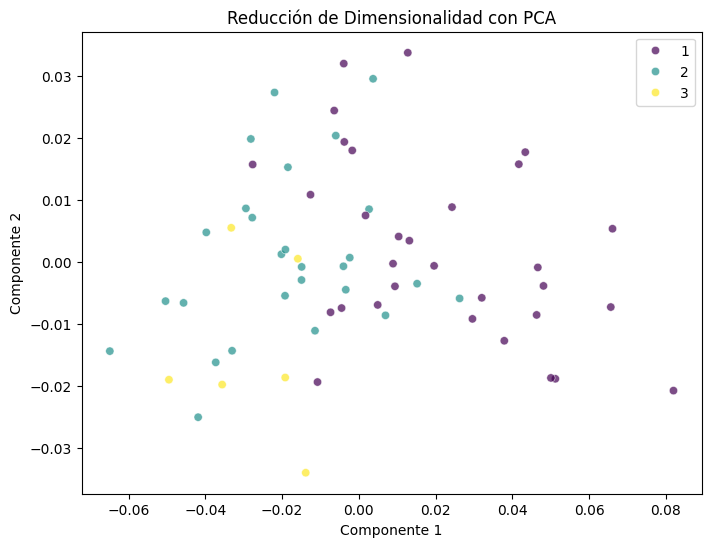

In [ ]:
from sklearn.decomposition import PCA

# Reducir a 2 dimensiones usando PCA
pca = PCA(n_components=2)
X_train_reduced = pca.fit_transform(X_train)

# Graficar las muestras proyectadas en 2D
plt.figure(figsize=(8,6))
sns.scatterplot(x=X_train_reduced[:, 0], y=X_train_reduced[:, 1], hue=y_train, palette="viridis", alpha=0.7)
plt.title("Reducción de Dimensionalidad con PCA")
plt.xlabel("Componente 1")
plt.ylabel("Componente 2")
plt.show()


# CON PYTHORCH (Inglés)

In [ ]:
!pip install transformers


In [ ]:
import os
import torch
import numpy as np
import pandas as pd
from transformers import AutoTokenizer, AutoModel

# Rutas
PROMPTS = "/content/drive/MyDrive/avances/embebidos/prompts_400_ing.csv"  # columnas: PATNO, prompts_400_ing, grupo
OUT_DIR = "/content/drive/MyDrive/avances/CLIP/embeddings-20251130T160205Z-1-001/embeddings/Text_pd"

os.makedirs(OUT_DIR, exist_ok=True)

# 1. Cargar CSV
df = pd.read_csv(PROMPTS)
print(df.columns)  # para verificar que estén 'PATNO', 'prompts_400_ing', 'grupo'

# (Opcional) filtrar por grupo si quieres solo PD
# df = df[df["grupo"] == "PD"]

# 2. Cargar ClinicalBERT
MODEL_NAME = "emilyalsentzer/Bio_ClinicalBERT"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModel.from_pretrained(MODEL_NAME)
model.to(device)
model.eval()

# 3. Función para obtener embeddings (CLS) de ClinicalBERT
def get_clinicalbert_embeddings(text_list, batch_size=16, max_length=128):
    """
    text_list: lista de strings (prompts)
    Devuelve: tensor [n_textos, dim] con el embedding CLS normalizado
    """
    all_embeddings = []

    with torch.no_grad():
        for i in range(0, len(text_list), batch_size):
            batch_texts = text_list[i:i + batch_size]

            encoded = tokenizer(
                batch_texts,
                padding=True,
                truncation=True,
                max_length=max_length,
                return_tensors="pt"
            )

            input_ids = encoded["input_ids"].to(device)
            attention_mask = encoded["attention_mask"].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            last_hidden_state = outputs.last_hidden_state  # [batch, seq_len, hidden_size]

            # Usamos el token [CLS]
            cls_embeddings = last_hidden_state[:, 0, :]  # [batch, hidden_size]

            # Normalizar cada vector
            cls_embeddings = cls_embeddings / cls_embeddings.norm(dim=-1, keepdim=True)

            all_embeddings.append(cls_embeddings.cpu())

    return torch.cat(all_embeddings, dim=0)  # [n_textos, dim]


# 4. Calcular embedding por paciente y guardar como .npy
for patno, sub_df in df.groupby("PATNO"):
    texts = sub_df["prompts_400_ing"].astype(str).tolist()

    if len(texts) == 0:
        continue

    # Embeddings de todos los prompts del paciente
    emb_prompts = get_clinicalbert_embeddings(texts, batch_size=16, max_length=128)  # [n_prompts_paciente, dim]

    # Promedio por paciente
    emb_patient = emb_prompts.mean(dim=0)  # [dim]
    emb_patient = emb_patient / emb_patient.norm()

    # Pasar a numpy
    emb_patient_np = emb_patient.numpy()  # shape (dim,)

    # Guardar cada paciente en un archivo .npy
    out_path = os.path.join(OUT_DIR, f"{patno}.npy")
    np.save(out_path, emb_patient_np)

    print(f"Guardado embedding .npy de paciente {patno} en {out_path}")


Index(['PATNO', 'grupo', 'prompts_400_ing'], dtype='object')
Guardado embedding .npy de paciente 3001 en /content/drive/MyDrive/avances/CLIP/embeddings-20251130T160205Z-1-001/embeddings/Text_pd/3001.npy
Guardado embedding .npy de paciente 3002 en /content/drive/MyDrive/avances/CLIP/embeddings-20251130T160205Z-1-001/embeddings/Text_pd/3002.npy
Guardado embedding .npy de paciente 3003 en /content/drive/MyDrive/avances/CLIP/embeddings-20251130T160205Z-1-001/embeddings/Text_pd/3003.npy
Guardado embedding .npy de paciente 3005 en /content/drive/MyDrive/avances/CLIP/embeddings-20251130T160205Z-1-001/embeddings/Text_pd/3005.npy
Guardado embedding .npy de paciente 3006 en /content/drive/MyDrive/avances/CLIP/embeddings-20251130T160205Z-1-001/embeddings/Text_pd/3006.npy
Guardado embedding .npy de paciente 3007 en /content/drive/MyDrive/avances/CLIP/embeddings-20251130T160205Z-1-001/embeddings/Text_pd/3007.npy
Guardado embedding .npy de paciente 3010 en /content/drive/MyDrive/avances/CLIP/embeddi